## Dataset

#### Checkerboard (prioritize this dataset)

In [141]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt


def generate_batch(num_datapoints: int) -> np.ndarray:
    """Checkerboard dataset."""
    x1 = np.random.rand(num_datapoints) * 4 - 2
    x2 = (
        np.random.rand(num_datapoints)
        - np.random.randint(0, 2, [num_datapoints]) * 2.0
        + np.floor(x1) % 2
    )
    data = np.stack([x1, x2]).T * 2
    data = (data - data.mean(axis=0)) / data.std(axis=0)  # normalize
    return torch.from_numpy(data.astype(np.float32))


train_data = generate_batch(5000)

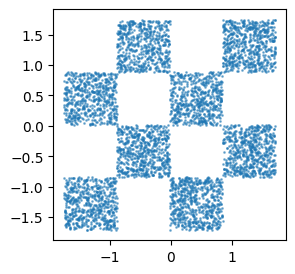

In [111]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:, 0], train_data.numpy()[:, 1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

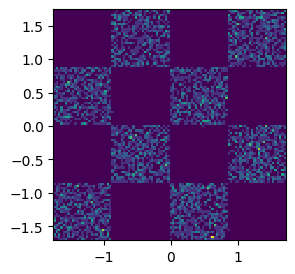

In [112]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:, 0], train_data.numpy()[:, 1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [143]:
import torch
import math
from sklearn import datasets
import numpy as np


# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset"""
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

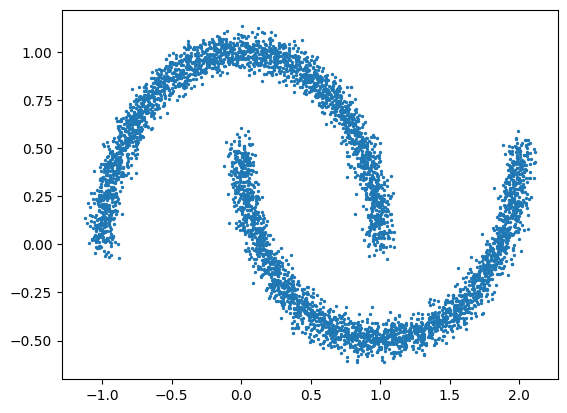

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:, 0], batch[:, 1], s=2.0)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

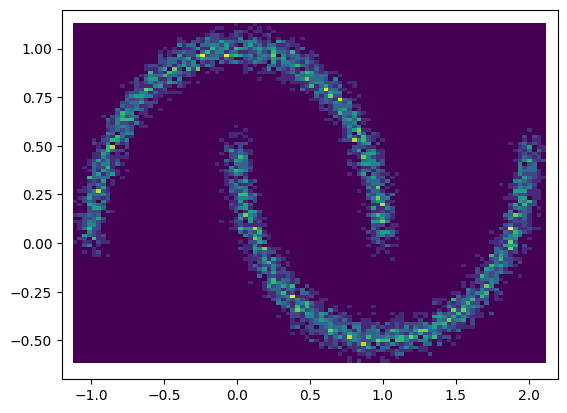

In [145]:
plt.hist2d(batch.numpy()[:, 0], batch.numpy()[:, 1], bins=100)
plt.xlim([-1.2, 2.2])
plt.ylim([-0.7, 1.2])
plt.show()

In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml

step 0: Normalized KL: 1.349e+00, rec : 9.277e-01, mean_dec_sigma: tensor([0.9999, 0.9996])


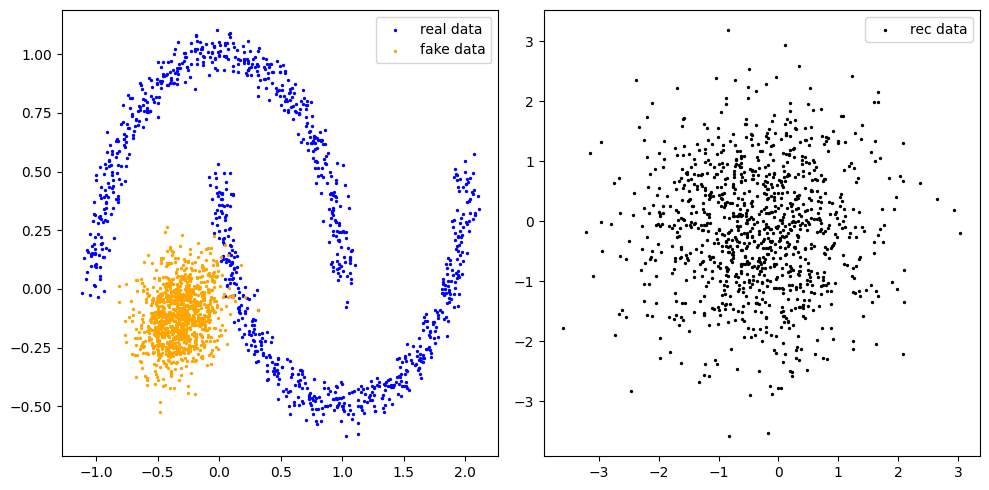

step 2000: Normalized KL: 2.380e+00, rec : -1.754e+00, mean_dec_sigma: tensor([0.3830, 0.3761])


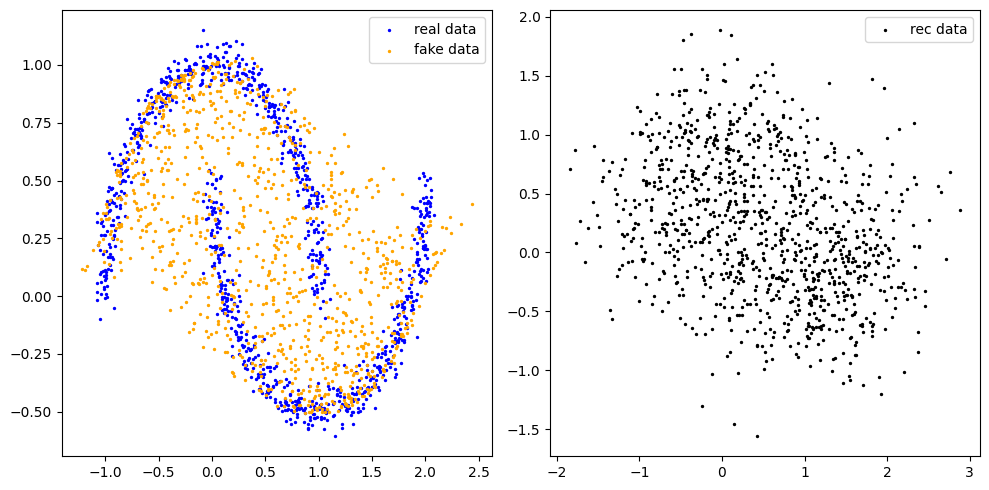

step 4000: Normalized KL: 3.209e+00, rec : -3.230e+00, mean_dec_sigma: tensor([0.1664, 0.1613])


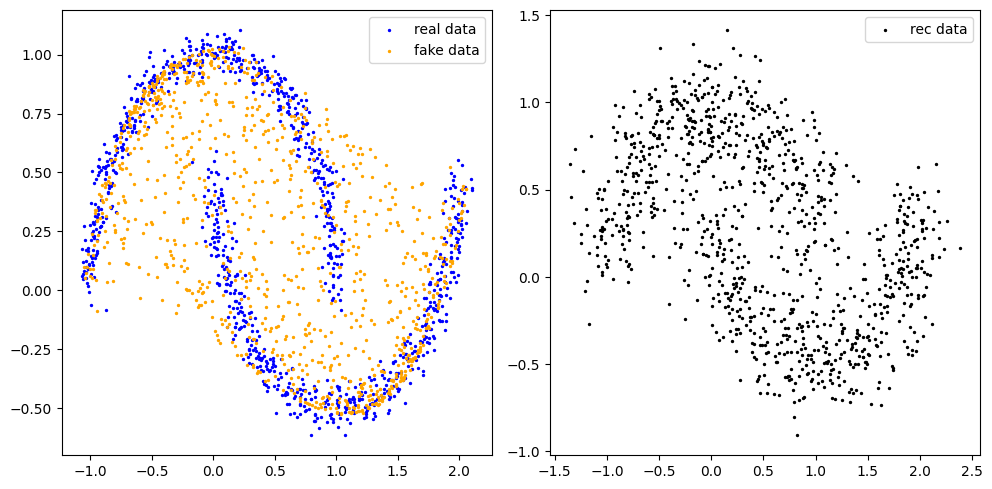

step 6000: Normalized KL: 3.822e+00, rec : -4.216e+00, mean_dec_sigma: tensor([0.0952, 0.0864])


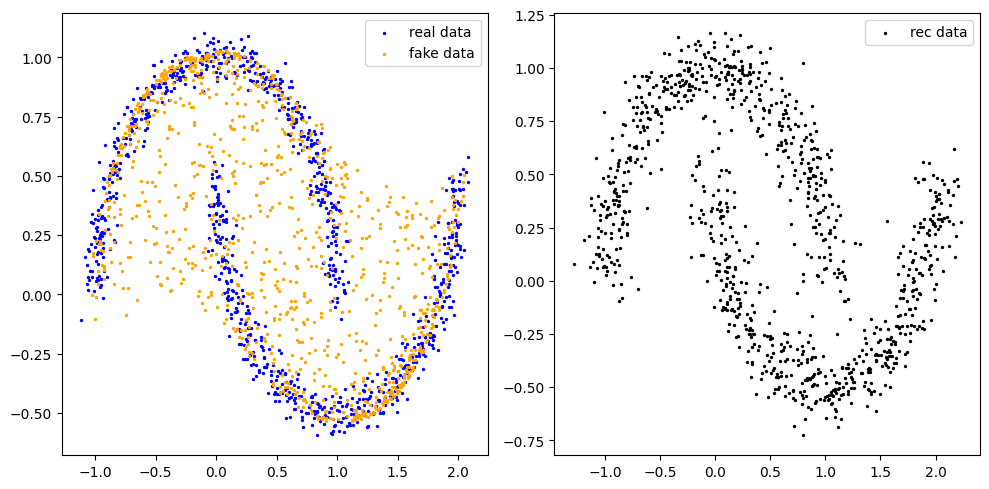

step 8000: Normalized KL: 4.080e+00, rec : -4.539e+00, mean_dec_sigma: tensor([0.0725, 0.0604])


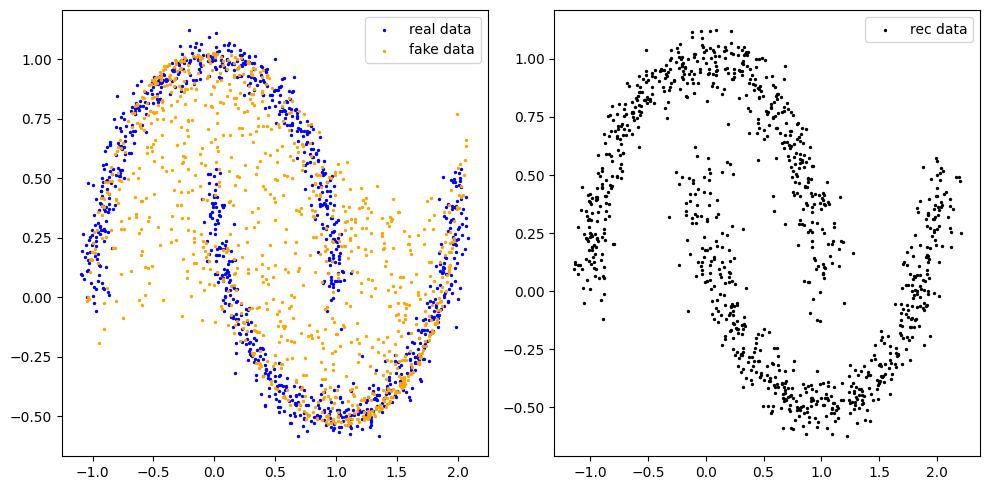

step 10000: Normalized KL: 4.059e+00, rec : -4.621e+00, mean_dec_sigma: tensor([0.0667, 0.0514])


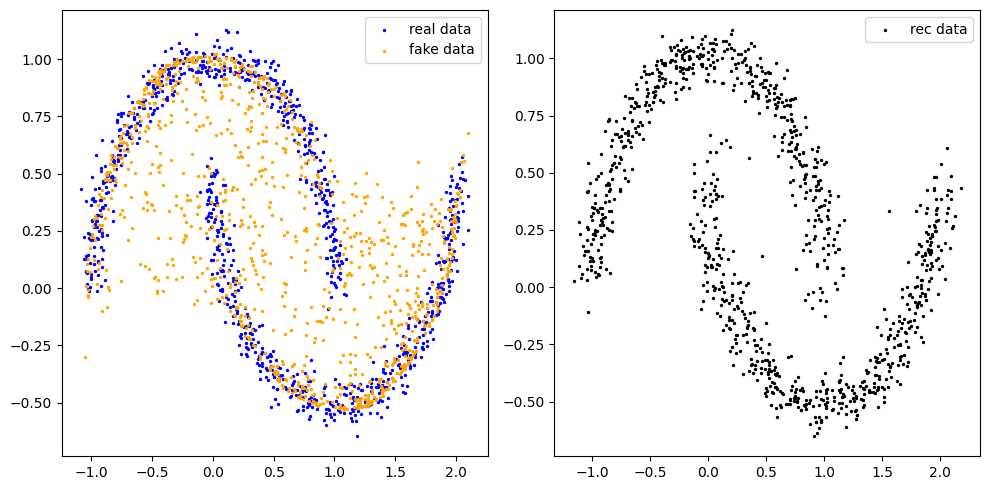

step 12000: Normalized KL: 4.138e+00, rec : -4.718e+00, mean_dec_sigma: tensor([0.0655, 0.0468])


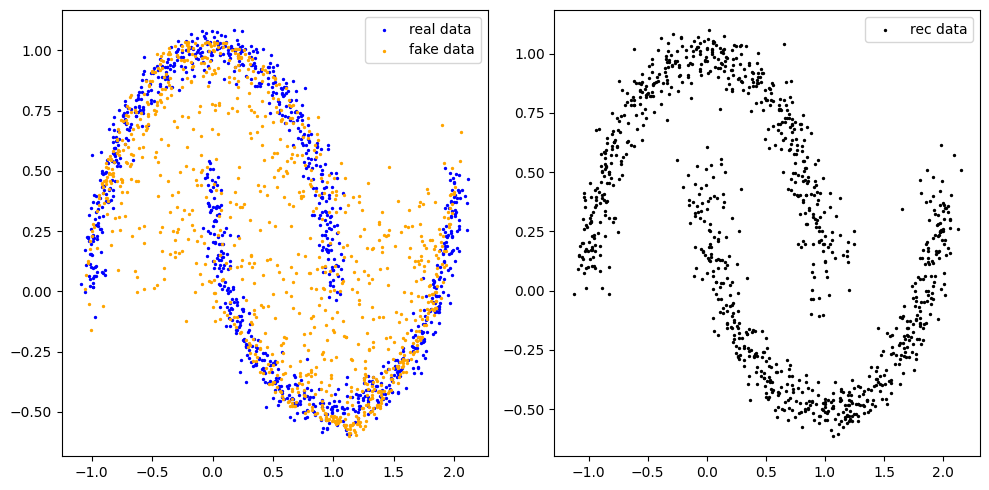

step 14000: Normalized KL: 4.150e+00, rec : -4.817e+00, mean_dec_sigma: tensor([0.0646, 0.0430])


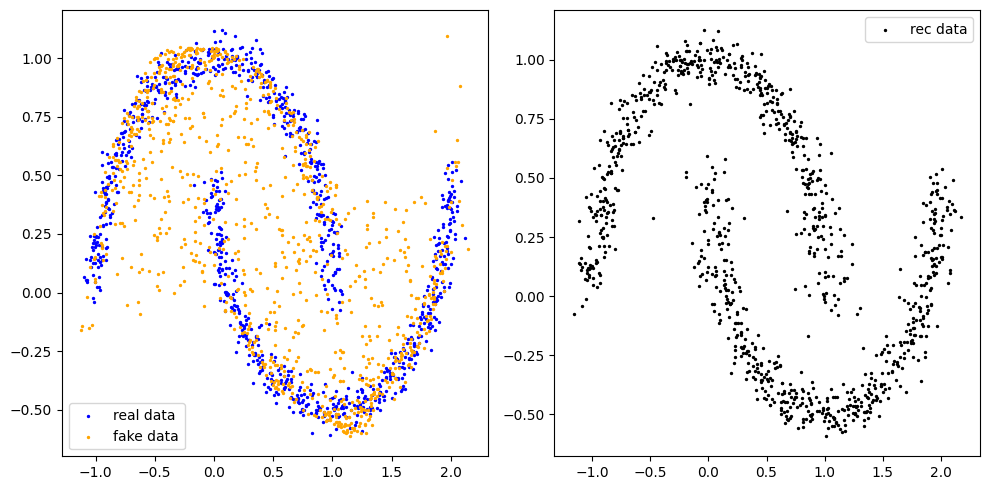

step 16000: Normalized KL: 4.199e+00, rec : -4.753e+00, mean_dec_sigma: tensor([0.0640, 0.0400])


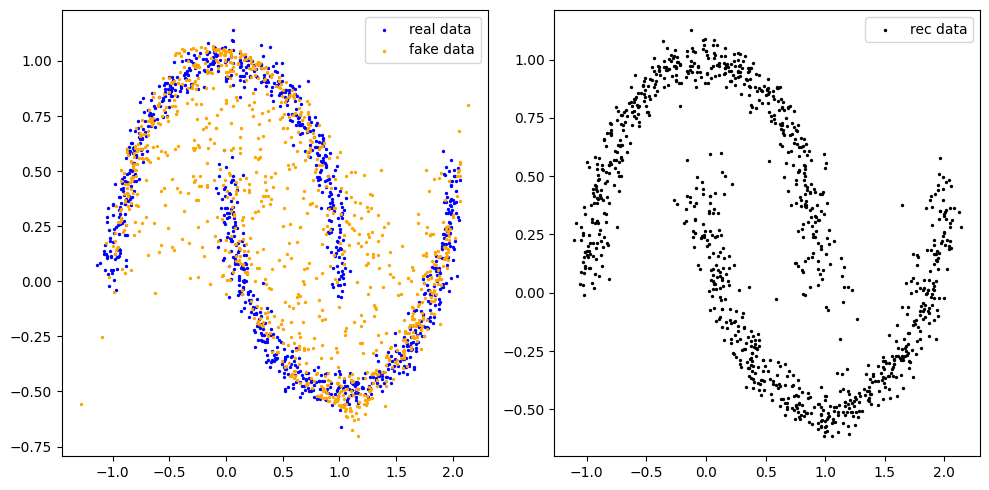

step 18000: Normalized KL: 4.294e+00, rec : -4.951e+00, mean_dec_sigma: tensor([0.0635, 0.0377])


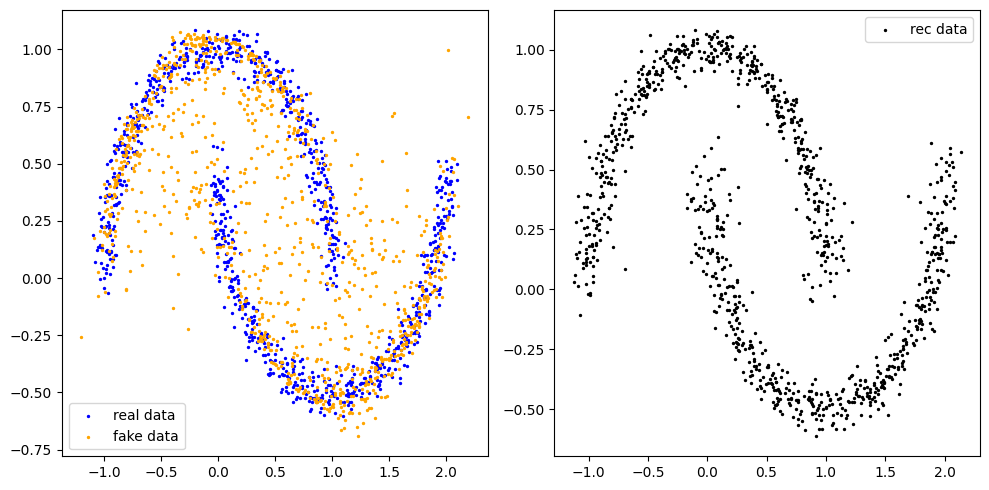

step 20000: Normalized KL: 4.344e+00, rec : -4.987e+00, mean_dec_sigma: tensor([0.0632, 0.0358])


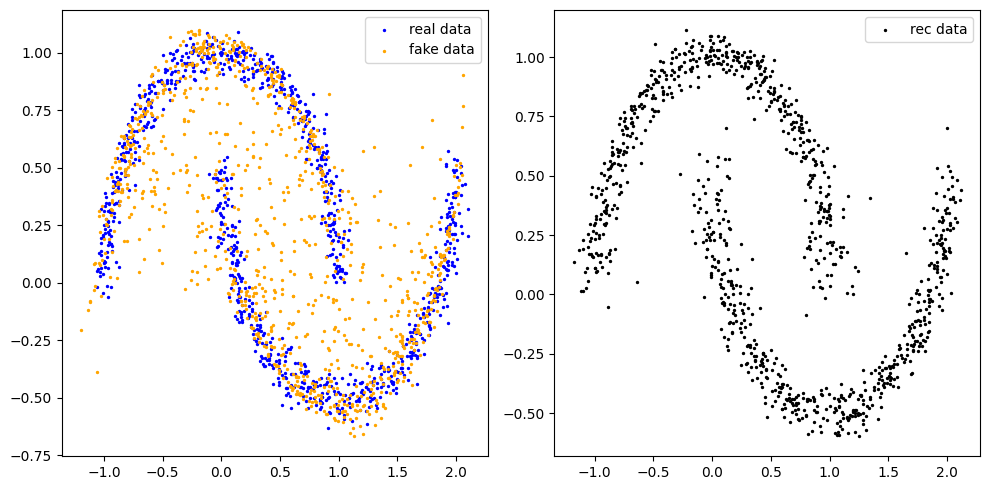

step 22000: Normalized KL: 4.400e+00, rec : -5.056e+00, mean_dec_sigma: tensor([0.0629, 0.0343])


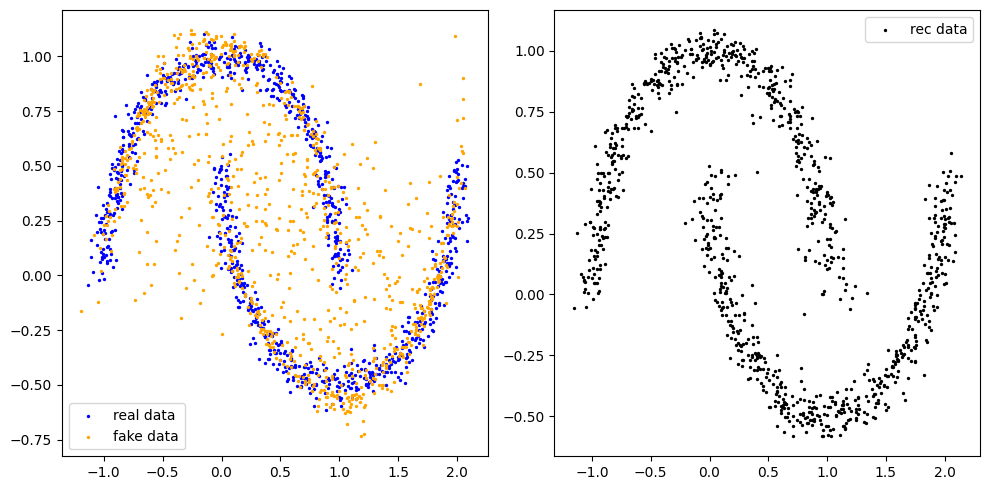

step 24000: Normalized KL: 4.397e+00, rec : -5.093e+00, mean_dec_sigma: tensor([0.0626, 0.0331])


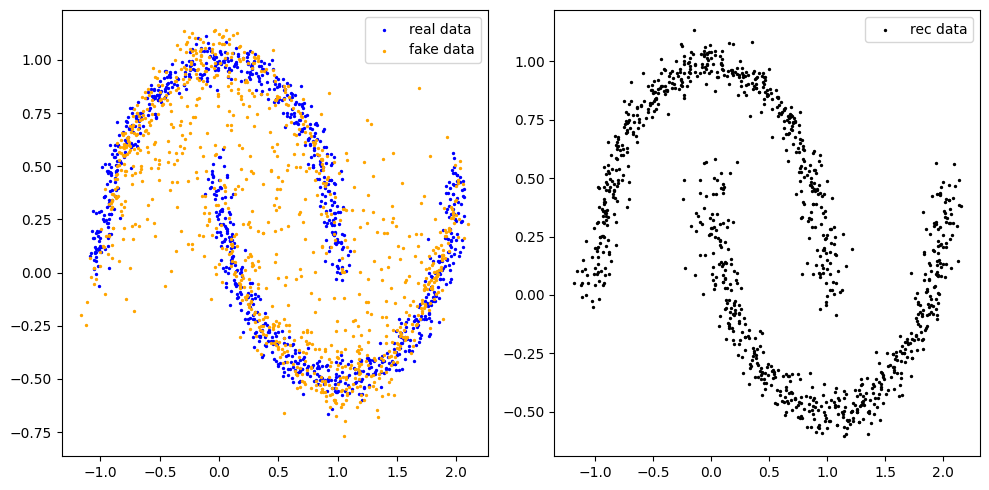

step 26000: Normalized KL: 4.392e+00, rec : -5.100e+00, mean_dec_sigma: tensor([0.0623, 0.0321])


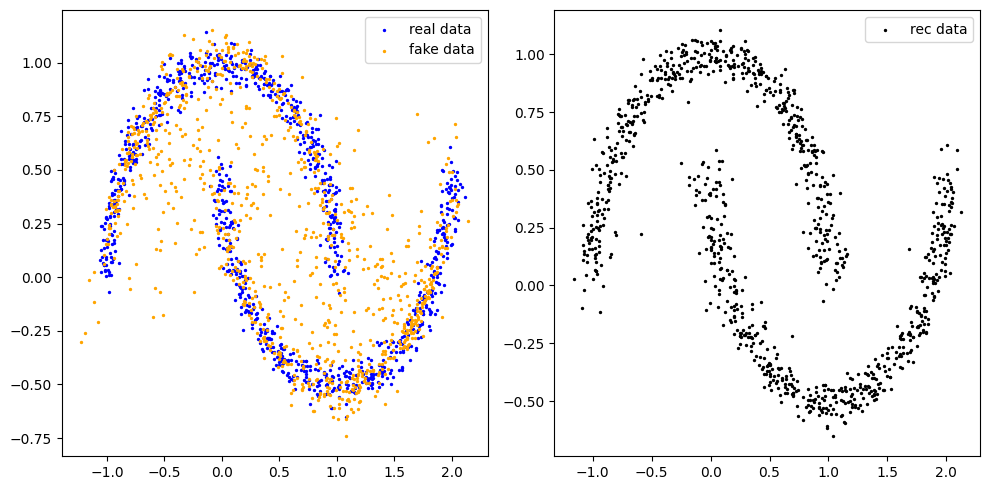

step 28000: Normalized KL: 4.416e+00, rec : -5.059e+00, mean_dec_sigma: tensor([0.0620, 0.0312])


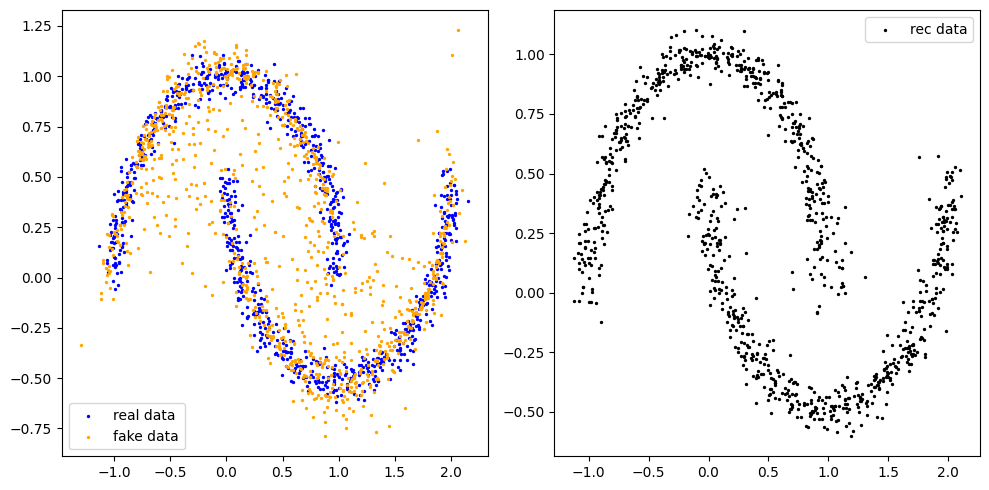

step 30000: Normalized KL: 4.384e+00, rec : -5.043e+00, mean_dec_sigma: tensor([0.0619, 0.0304])


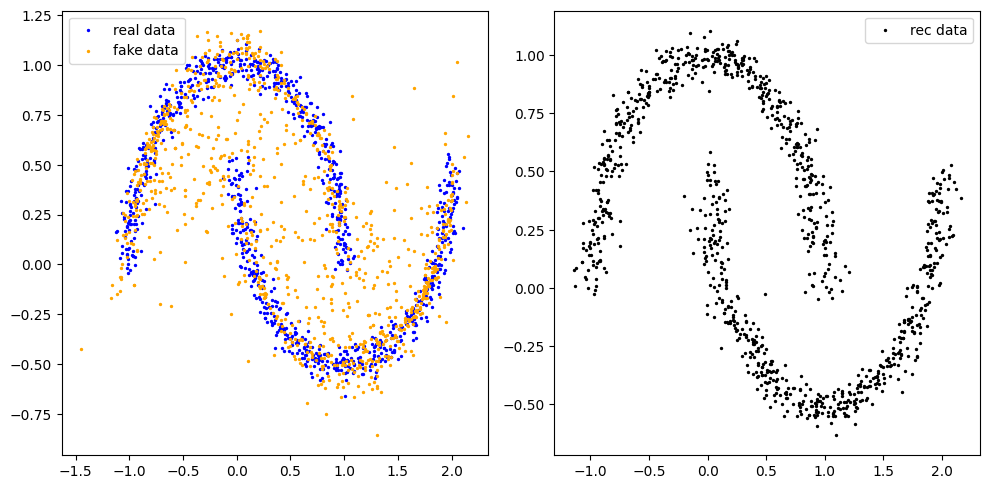

step 32000: Normalized KL: 4.457e+00, rec : -5.107e+00, mean_dec_sigma: tensor([0.0618, 0.0297])


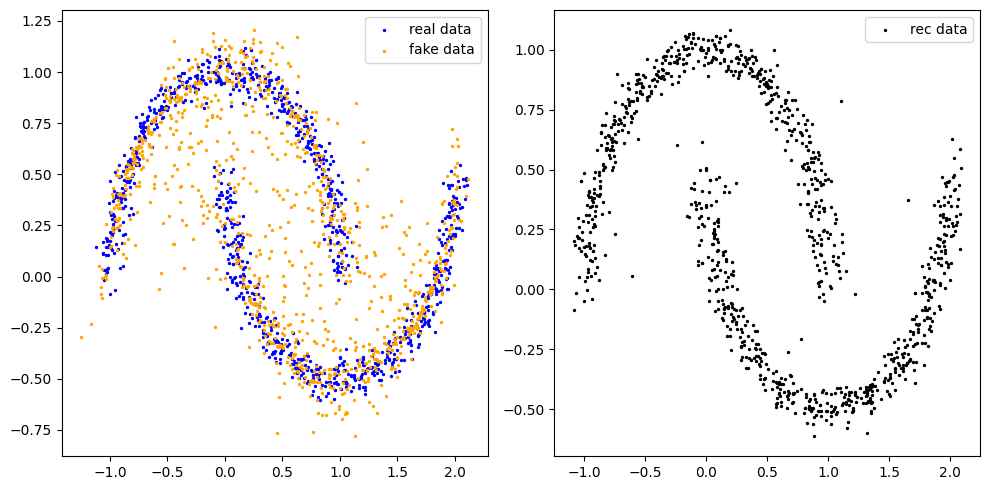

step 34000: Normalized KL: 4.424e+00, rec : -5.036e+00, mean_dec_sigma: tensor([0.0617, 0.0290])


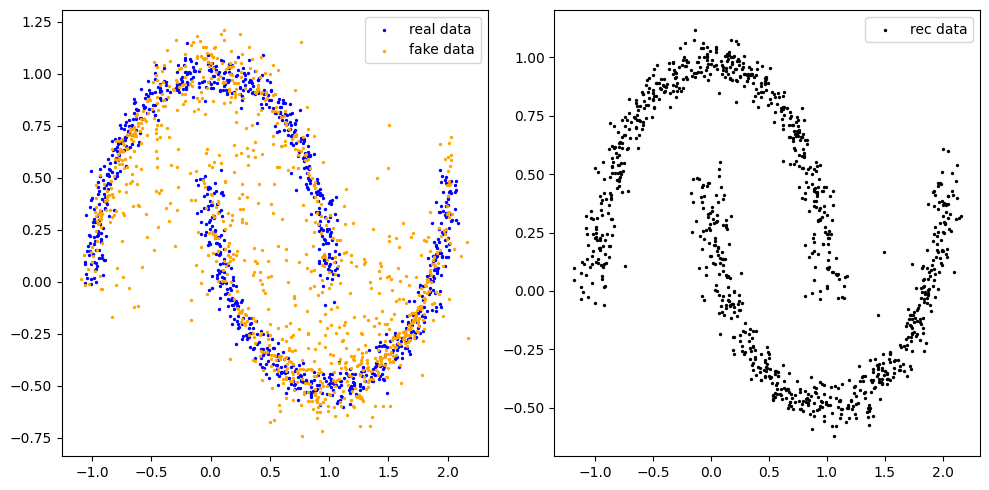

step 36000: Normalized KL: 4.483e+00, rec : -5.083e+00, mean_dec_sigma: tensor([0.0616, 0.0284])


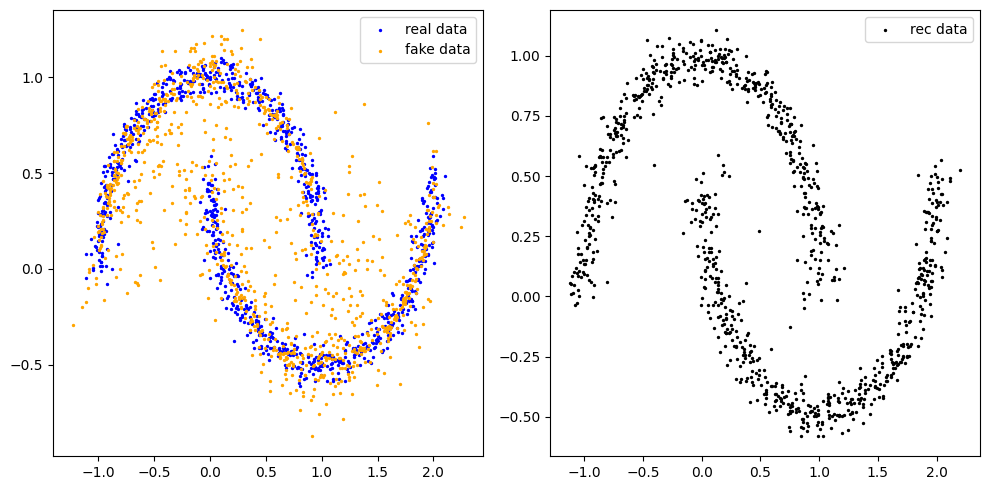

step 38000: Normalized KL: 4.515e+00, rec : -5.122e+00, mean_dec_sigma: tensor([0.0615, 0.0278])


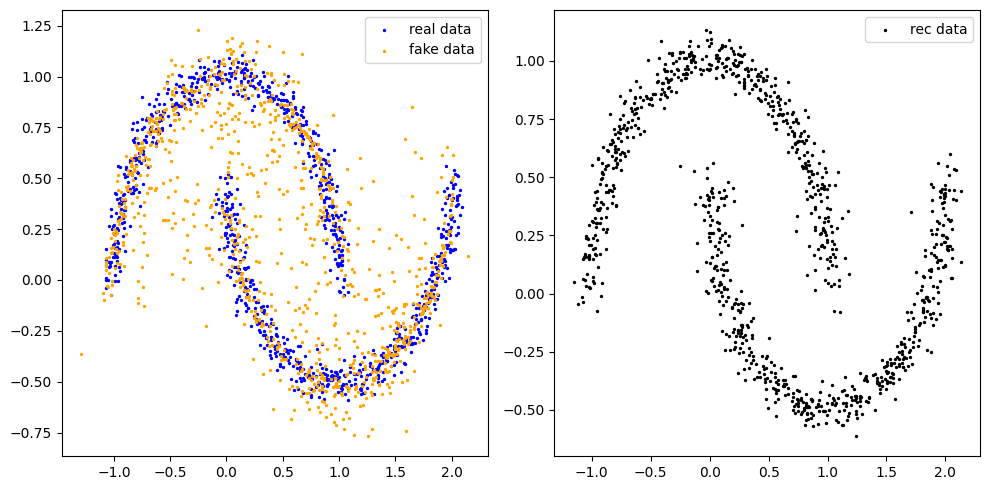

step 40000: Normalized KL: 4.518e+00, rec : -5.250e+00, mean_dec_sigma: tensor([0.0614, 0.0272])


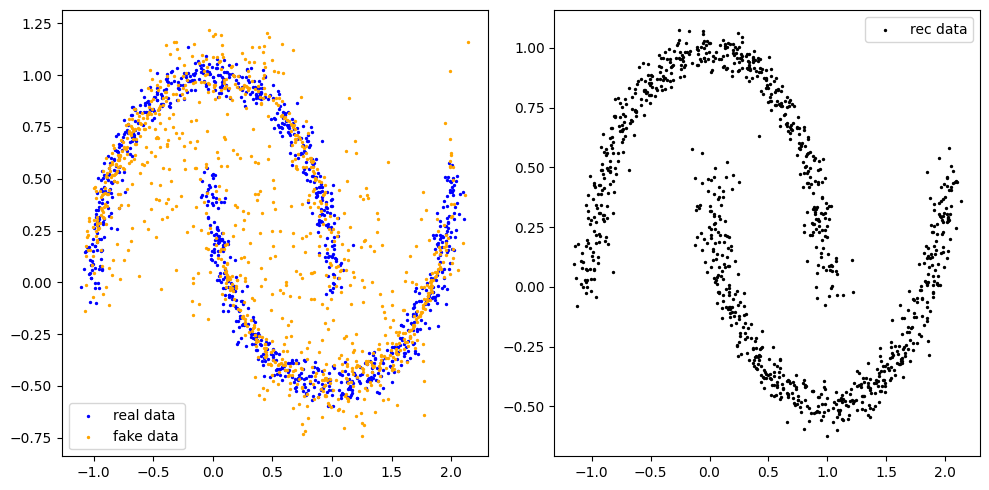

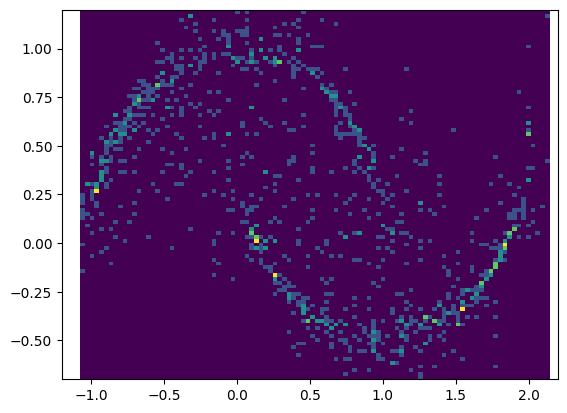

In [153]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

BATCHLEN = config["BATCHLEN"]
N_ITER = config["N_ITER"]
LR = config["LR"]
LATENT_N = config["LATENT_N"]
PRINT_EVERY = config["PRINT_EVERY"]


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Sequential(
            nn.Linear(2, LATENT_N // 2),
            nn.ELU(),
            nn.Linear(LATENT_N // 2, LATENT_N // 2),
            nn.ELU(),
            nn.Linear(LATENT_N // 2, LATENT_N),
        )
        self.fc_logvar = nn.Sequential(
            nn.Linear(2, LATENT_N // 2),
            nn.ELU(),
            nn.Linear(LATENT_N // 2, LATENT_N // 2),
            nn.ELU(),
            nn.Linear(LATENT_N // 2, LATENT_N),
        )

    def forward(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)


# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Sequential(
            nn.Linear(LATENT_N, LATENT_N // 2),
            nn.ELU(),
            nn.Linear(LATENT_N // 2, LATENT_N // 2),
            nn.ELU(),
            nn.Linear(LATENT_N // 2, 2),
        )
        self.fc_logvar = nn.Parameter(
            torch.zeros((BATCHLEN, 2))
        )  # Initialize the variance to zero to push it down
        # self.fc_logvar = torch.ones((BATCHLEN, 2)) * -10.0

    def forward(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar
        return (mu, logvar)
        # return (mu, torch.ones_like(mu) * -5)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self(z)
        # return torch.normal(mu, torch.exp(0.5 * logvar))
        return mu  # deterministic generator for now


encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=LR, betas=(0.5, 0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=LR, betas=(0.5, 0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)

    # beta = min(1, max(((i + 1) / 10000), 0.5))
    beta = min(1, (i + 1) / 10000)
    # beta = 1

    loss_kl = (
        beta
        * (
            torch.sum(enc_mu**2)
            + torch.sum(torch.exp(enc_logvar))
            - torch.sum(enc_logvar)
            - LATENT_N * BATCHLEN
        )
        / (2 * BATCHLEN)
    )

    z = enc_mu + torch.exp(0.5 * enc_logvar) * torch.randn(BATCHLEN, LATENT_N)

    dec_mu, dec_logvar = decoder(z)

    loss_rec = (
        0.5 * torch.sum(dec_logvar)
        + 0.5 * torch.sum(((x - dec_mu) / (torch.exp(0.5 * dec_logvar))) ** 2)
    ) / BATCHLEN

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i % PRINT_EVERY == 0:
        with torch.no_grad():
            print(
                "step {}: Normalized KL: {:.3e}, rec : {:.3e}, mean_dec_sigma: {}".format(
                    i,
                    float(loss_kl) / beta,
                    float(loss_rec),
                    torch.exp(0.5 * dec_logvar).mean(axis=0),
                )
            )
            # plot the result
            z_prior = torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0)
            real_batch = generate_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5 * dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.scatter(
                real_batch[:, 0], real_batch[:, 1], s=2.0, label="real data", c="blue"
            )
            # plt.scatter(
            #     dec_mu[:, 0],
            #     dec_mu[:, 1],
            #     s=2.0,
            #     label="rec mu"
            #     c="red",
            # )
            # plt.scatter(z_prior[:, 0], z_prior[:, 1], s=2.0, label="prior", c="orange")
            # plt.scatter(z[:, 0], z[:, 1], s=2.0, label="latent space", c="green")
            ax2.scatter(
                rec_batch[:, 0], rec_batch[:, 1], s=2.0, c="black", label="rec data"
            )
            ax2.legend()
            ax1.scatter(
                fake_batch[:, 0], fake_batch[:, 1], s=2.0, label="fake data", c="orange"
            )
            ax1.legend()
            plt.tight_layout()
            plt.show()


plt.hist2d(fake_batch.numpy()[:, 0], fake_batch.numpy()[:, 1], bins=100)
plt.xlim([-1.2, 2.2])
plt.ylim([-0.7, 1.2])
plt.show()

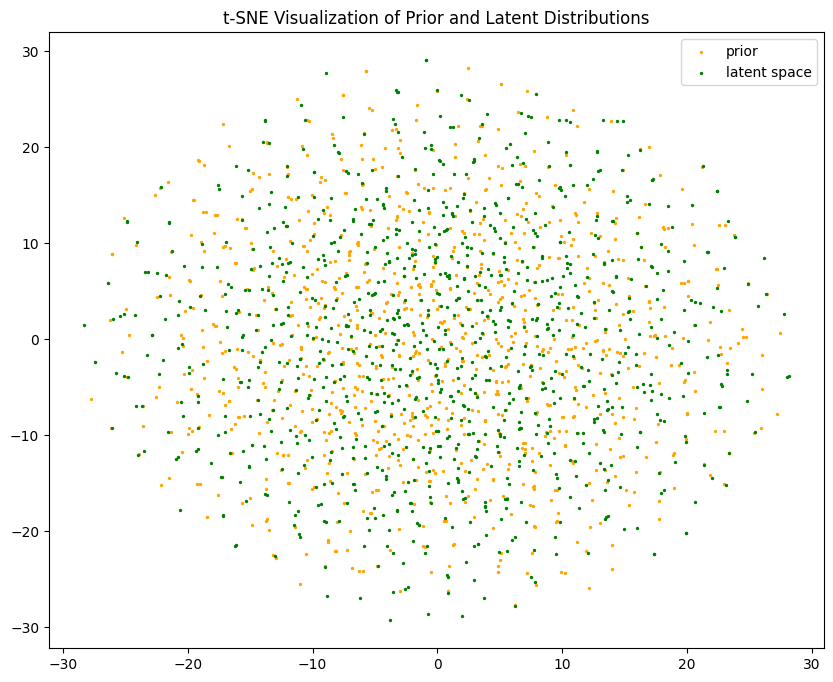

In [148]:
from sklearn.manifold import TSNE

combined_data = np.vstack([z_prior.detach().numpy(), z.detach().numpy()])

# Create a label array to keep track of which points came from which distribution
labels = np.array(["prior"] * len(z_prior) + ["latent"] * len(z))

# Apply t-SNE to the combined data
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(combined_data)

# Split the results back into the two original sets
tsne_z_prior = tsne_results[: len(z_prior)]
tsne_z = tsne_results[len(z_prior) :]

# Now you can plot them
plt.figure(figsize=(10, 8))
plt.scatter(tsne_z_prior[:, 0], tsne_z_prior[:, 1], s=2.0, label="prior", c="orange")
plt.scatter(tsne_z[:, 0], tsne_z[:, 1], s=2.0, label="latent space", c="green")
plt.title("t-SNE Visualization of Prior and Latent Distributions")
plt.legend()
plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here, observe the plots)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**